In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
import os
import numpy as np
import astropy.units as u
from astropy.coordinates import SkyCoord, Angle
from regions import CircleSkyRegion
from gammapy.spectrum import (
    SpectrumDatasetOnOff,
    SpectrumDataset,
    SpectrumDatasetMaker,
)
from gammapy.modeling import Fit, Parameter
from gammapy.modeling.models import (
    PowerLawSpectralModel,
    SpectralModel,
    SkyModel,
    ExpCutoffPowerLawSpectralModel,
)
from gammapy.irf import load_cta_irfs
from gammapy.data import Observation
from gammapy.maps import MapAxis

In [3]:
livetime = 48 * u.h
pointing = SkyCoord(0, 0, unit="deg", frame="galactic")
offset = 0.5 * u.deg
# Reconstructed and true energy axis
energy_axis = MapAxis.from_edges(
    np.logspace(-1.5, 2.0, 10), unit="TeV", name="energy", interp="log"
)
energy_axis_true = MapAxis.from_edges(
    np.logspace(-1.5, 2.0, 31), unit="TeV", name="energy", interp="log"
)

on_region_radius = Angle("0.11 deg")
on_region = CircleSkyRegion(center=pointing, radius=on_region_radius)

In [4]:
# Define spectral model - a simple Power Law in this case
model_simu = ExpCutoffPowerLawSpectralModel(
    index=2.22,
    amplitude=1.289e-12 * u.Unit("cm-2 s-1 TeV-1"),
    reference=1 * u.TeV,
    lambda_=0.3 * u.Unit("TeV-1"),
    alpha = 1,
)
print(model_simu)
# we set the sky model used in the dataset
model = SkyModel(spectral_model=model_simu)

ExpCutoffPowerLawSpectralModel

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.220e+00   nan                nan nan  False
amplitude 1.289e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 3.000e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True


In [5]:
os.environ['CALDB'] = '/home/rishank/anaconda2/envs/cta/share/caldb/'
!echo $CALDB
!ls $CALDB

/home/rishank/anaconda2/envs/cta/share/caldb/
data


In [6]:
# Load the IRFs
# In this simulation, we use the CTA-1DC irfs shipped with gammapy.
irfs = load_cta_irfs(
    "$CALDB/data/cta/prod3b-v2/bcf/South_z20_50h/irf_file.fits"
)

In [7]:
obs = Observation.create(pointing=pointing, livetime=livetime, irfs=irfs)
print(obs)

Info for OBS_ID = 1
- Pointing pos: RA 266.40 deg / Dec -28.94 deg
- Livetime duration: 172800.0 s



In [8]:
# Make the SpectrumDataset
dataset_empty = SpectrumDataset.create(
    e_reco=energy_axis.edges, e_true=energy_axis_true.edges, region=on_region
)
maker = SpectrumDatasetMaker(selection=["aeff", "edisp", "background"])
dataset = maker.run(dataset_empty, obs)

In [9]:
# Set the model on the dataset, and fake
dataset.model = model
dataset.fake(random_state=42)
print(dataset)

SpectrumDataset

    Name                            : 1 

    Total counts                    : 20280 
    Total predicted counts          : nan
    Total background counts         : 20309.41

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 1.73e+05 s

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : cash
    Fit statistic value (-2 log(L)) : nan

    Number of parameters            : 0
    Number of free parameters       : 0




In [10]:
dataset_onoff = SpectrumDatasetOnOff(
    aeff=dataset.aeff,
    edisp=dataset.edisp,
    models=model,
    livetime=livetime,
    acceptance=1,
    acceptance_off=5,
)
dataset_onoff.fake(background_model=dataset.background)
print(dataset_onoff)

SpectrumDatasetOnOff

    Name                            :  

    Total counts                    : 33853 
    Total predicted counts          : 34236.74
    Total off counts                : 101509.00

    Total background counts         : 20301.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 8.36

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0



In [11]:

%%time

n_obs = 500
datasets = []

for idx in range(n_obs):
    dataset_onoff.fake(random_state=idx, background_model=dataset.background)
    dataset_onoff.name = f"obs_{idx}"
    datasets.append(dataset_onoff.copy())

CPU times: user 1.77 s, sys: 3.61 ms, total: 1.78 s
Wall time: 1.78 s


In [12]:
print(*datasets, sep = "\n") 

SpectrumDatasetOnOff

    Name                            : obs_0 

    Total counts                    : 34383 
    Total predicted counts          : 34347.94
    Total off counts                : 102065.00

    Total background counts         : 20413.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 8.73

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1 

    Total counts                    : 34005 
    Total predicted counts          : 34232.74
    Total off counts                : 101489.00

    Total background counts         : 20

SpectrumDatasetOnOff

    Name                            : obs_30 

    Total counts                    : 34426 
    Total predicted counts          : 34192.54
    Total off counts                : 101288.00

    Total background counts         : 20257.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 10.73

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_31 

    Total counts                    : 33988 
    Total predicted counts          : 34191.94
    Total off counts                : 101285.00

    Total background counts         :

SpectrumDatasetOnOff

    Name                            : obs_47 

    Total counts                    : 34478 
    Total predicted counts          : 34275.94
    Total off counts                : 101705.00

    Total background counts         : 20341.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 7.64

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_48 

    Total counts                    : 34017 
    Total predicted counts          : 34115.14
    Total off counts                : 100901.00

    Total background counts         : 

SpectrumDatasetOnOff

    Name                            : obs_73 

    Total counts                    : 34635 
    Total predicted counts          : 34187.34
    Total off counts                : 101262.00

    Total background counts         : 20252.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 13.88

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_74 

    Total counts                    : 34377 
    Total predicted counts          : 34210.34
    Total off counts                : 101377.00

    Total background counts         :

SpectrumDatasetOnOff

    Name                            : obs_94 

    Total counts                    : 34315 
    Total predicted counts          : 34185.94
    Total off counts                : 101255.00

    Total background counts         : 20251.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 11.05

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_95 

    Total counts                    : 34187 
    Total predicted counts          : 34206.14
    Total off counts                : 101356.00

    Total background counts         :

SpectrumDatasetOnOff

    Name                            : obs_114 

    Total counts                    : 34445 
    Total predicted counts          : 34230.74
    Total off counts                : 101479.00

    Total background counts         : 20295.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 13.59

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_115 

    Total counts                    : 34435 
    Total predicted counts          : 34380.34
    Total off counts                : 102227.00

    Total background counts        


SpectrumDatasetOnOff

    Name                            : obs_142 

    Total counts                    : 34398 
    Total predicted counts          : 34196.74
    Total off counts                : 101309.00

    Total background counts         : 20261.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 8.07

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_143 

    Total counts                    : 34155 
    Total predicted counts          : 34278.54
    Total off counts                : 101718.00

    Total background counts        

SpectrumDatasetOnOff

    Name                            : obs_168 

    Total counts                    : 34461 
    Total predicted counts          : 34238.94
    Total off counts                : 101520.00

    Total background counts         : 20304.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 6.07

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_169 

    Total counts                    : 34197 
    Total predicted counts          : 34233.34
    Total off counts                : 101492.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_192 

    Total counts                    : 34210 
    Total predicted counts          : 34329.74
    Total off counts                : 101974.00

    Total background counts         : 20394.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 9.43

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_193 

    Total counts                    : 34277 
    Total predicted counts          : 34212.54
    Total off counts                : 101388.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_213 

    Total counts                    : 34117 
    Total predicted counts          : 34213.94
    Total off counts                : 101395.00

    Total background counts         : 20279.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 4.64

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_214 

    Total counts                    : 34091 
    Total predicted counts          : 34174.74
    Total off counts                : 101199.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_241 

    Total counts                    : 34621 
    Total predicted counts          : 34195.94
    Total off counts                : 101305.00

    Total background counts         : 20261.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 9.61

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_242 

    Total counts                    : 34266 
    Total predicted counts          : 34119.74
    Total off counts                : 100924.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_273 

    Total counts                    : 34283 
    Total predicted counts          : 34284.34
    Total off counts                : 101747.00

    Total background counts         : 20349.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 6.51

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_274 

    Total counts                    : 34191 
    Total predicted counts          : 34321.34
    Total off counts                : 101932.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_296 

    Total counts                    : 34335 
    Total predicted counts          : 34280.14
    Total off counts                : 101726.00

    Total background counts         : 20345.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 4.27

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_297 

    Total counts                    : 34151 
    Total predicted counts          : 34250.94
    Total off counts                : 101580.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_323 

    Total counts                    : 34272 
    Total predicted counts          : 34201.74
    Total off counts                : 101334.00

    Total background counts         : 20266.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 7.33

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_324 

    Total counts                    : 34178 
    Total predicted counts          : 34304.74
    Total off counts                : 101849.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_344 

    Total counts                    : 34165 
    Total predicted counts          : 34234.14
    Total off counts                : 101496.00

    Total background counts         : 20299.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 9.61

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_345 

    Total counts                    : 34158 
    Total predicted counts          : 34249.14
    Total off counts                : 101571.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_361 

    Total counts                    : 34544 
    Total predicted counts          : 34196.34
    Total off counts                : 101307.00

    Total background counts         : 20261.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 5.97

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_362 

    Total counts                    : 34251 
    Total predicted counts          : 34220.94
    Total off counts                : 101430.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_379 

    Total counts                    : 34326 
    Total predicted counts          : 34253.34
    Total off counts                : 101592.00

    Total background counts         : 20318.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 2.95

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_380 

    Total counts                    : 34294 
    Total predicted counts          : 34373.54
    Total off counts                : 102193.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_395 

    Total counts                    : 34232 
    Total predicted counts          : 34238.34
    Total off counts                : 101517.00

    Total background counts         : 20303.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 5.92

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_396 

    Total counts                    : 34387 
    Total predicted counts          : 34206.94
    Total off counts                : 101360.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_408 

    Total counts                    : 34430 
    Total predicted counts          : 34248.34
    Total off counts                : 101567.00

    Total background counts         : 20313.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 4.88

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_409 

    Total counts                    : 34139 
    Total predicted counts          : 34216.54
    Total off counts                : 101408.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_432 

    Total counts                    : 34720 
    Total predicted counts          : 34289.34
    Total off counts                : 101772.00

    Total background counts         : 20354.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 8.33

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_433 

    Total counts                    : 34244 
    Total predicted counts          : 34201.74
    Total off counts                : 101334.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_455 

    Total counts                    : 34177 
    Total predicted counts          : 34334.54
    Total off counts                : 101998.00

    Total background counts         : 20399.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 8.36

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_456 

    Total counts                    : 34300 
    Total predicted counts          : 34280.54
    Total off counts                : 101728.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_480 

    Total counts                    : 34545 
    Total predicted counts          : 34245.74
    Total off counts                : 101554.00

    Total background counts         : 20310.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 6.71

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_481 

    Total counts                    : 34310 
    Total predicted counts          : 34223.54
    Total off counts                : 101443.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_498 

    Total counts                    : 34440 
    Total predicted counts          : 34222.14
    Total off counts                : 101436.00

    Total background counts         : 20287.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 3.54

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_499 

    Total counts                    : 34683 
    Total predicted counts          : 34260.94
    Total off counts                : 101630.00

    Total background counts         

Text(0, 0.5, 'No. of observations')

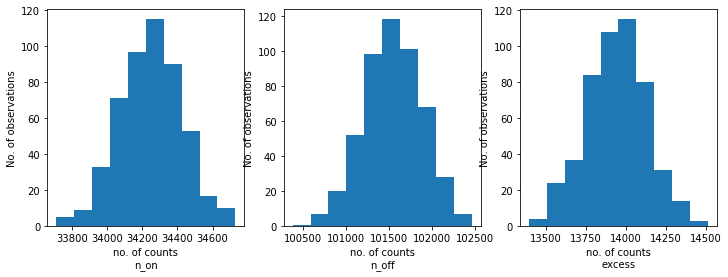

In [13]:

n_on = [dataset.counts.data.sum() for dataset in datasets]
n_off = [dataset.counts_off.data.sum() for dataset in datasets]
excess = [dataset.excess.data.sum() for dataset in datasets]

fix, axes = plt.subplots(1, 3, figsize=(12, 4))
axes[0].hist(n_on)
axes[0].set_xlabel("no. of counts\nn_on")
axes[0].set_ylabel("No. of observations")
axes[1].hist(n_off)
axes[1].set_xlabel("no. of counts\nn_off")
axes[1].set_ylabel("No. of observations")
axes[2].hist(excess)
axes[2].set_xlabel("no. of counts\nexcess");
axes[2].set_ylabel("No. of observations")

In [14]:

%%time
results = []
for dataset in datasets:
    dataset.models = model.copy()
    fit = Fit([dataset])
    result = fit.optimize()
    results.append(
        {
            "index": result.parameters["index"].value,
            "amplitude": result.parameters["amplitude"].value,
            "lambda_": result.parameters["lambda_"].value,
        }
    )

CPU times: user 1min 36s, sys: 322 ms, total: 1min 36s
Wall time: 1min 36s


In [15]:
results

[{'index': 2.2169905875495766,
  'amplitude': 1.2845712545260467e-12,
  'lambda_': 0.2801792257657554},
 {'index': 2.2324943380030526,
  'amplitude': 1.2364897746094746e-12,
  'lambda_': 0.28570927813929065},
 {'index': 2.236715787152109,
  'amplitude': 1.2640466245835502e-12,
  'lambda_': 0.3058093664482174},
 {'index': 2.2262640878970683,
  'amplitude': 1.2624740793001813e-12,
  'lambda_': 0.302405819333618},
 {'index': 2.2385731783387843,
  'amplitude': 1.276663483135211e-12,
  'lambda_': 0.30673699196054943},
 {'index': 2.1992461618258976,
  'amplitude': 1.3302284553934254e-12,
  'lambda_': 0.3431724199735729},
 {'index': 2.2416099341604867,
  'amplitude': 1.243665549675842e-12,
  'lambda_': 0.2871674134846505},
 {'index': 2.2238247278324987,
  'amplitude': 1.2845374429121784e-12,
  'lambda_': 0.3019087052854374},
 {'index': 2.2235248230739075,
  'amplitude': 1.248766419923766e-12,
  'lambda_': 0.27479277111955186},
 {'index': 2.2589641058301537,
  'amplitude': 1.1745196406545453e-

index: 2.219389302547137 += 0.01941848110424698


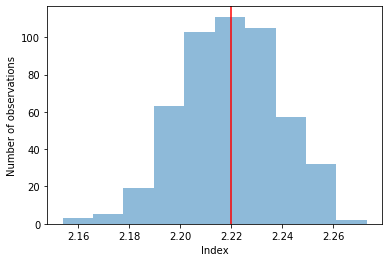

In [16]:
index = np.array([_["index"] for _ in results])
plt.hist(index, bins=10, alpha=0.5)
plt.axvline(x=model_simu.parameters["index"].value, color="red")
plt.xlabel("Index")
plt.ylabel("Number of observations")
print(f"index: {index.mean()} += {index.std()}")

amplitude: 1.2927615963436678e-12 += 5.00579005623978e-14


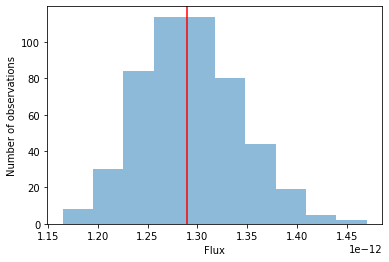

In [17]:
amplitude = np.array([_["amplitude"] for _ in results])
plt.hist(amplitude, bins=10, alpha=0.5)
plt.axvline(x=model_simu.parameters["amplitude"].value, color="red")
plt.xlabel("Flux")
plt.ylabel("Number of observations")
print(f"amplitude: {amplitude.mean()} += {amplitude.std()}")

lambda_: 0.3020786114718322 += 0.023978175790440776


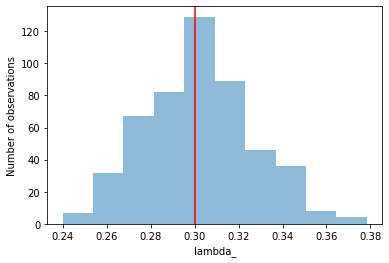

In [18]:
lambda_ = np.array([_["lambda_"] for _ in results])
plt.hist(lambda_, bins=10, alpha=0.5)
plt.axvline(x=model_simu.parameters["lambda_"].value, color="red")
plt.xlabel("lambda_")
plt.ylabel("Number of observations")
print(f"lambda_: {lambda_.mean()} += {lambda_.std()}")